# Test ray tracing

Goal of this notebook is to use Cosmogrid simulations to test the raytracing pipeline & Born pipeline, comparing it with theory

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import CMB_lensing_SBI
from CMB_lensing_SBI.healpy_utils import *
from CMB_lensing_SBI.PKDGRAV_utilities_scripts import *
from CMB_lensing_SBI.Raytracing import *
from CMB_lensing_SBI.Theory_camb import theory,cosmo
import CMB_lensing_SBI.Bornraytrace as Bornraytrace
import os
import healpy as hp
import astropy
import astropy.io.fits as fits
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM,wCDM
from astropy.cosmology import z_at_value
import frogress
import copy
import camb
from camb import model, initialpower
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import unyt
import yaml
from ekit import paths as path_tools
import camb
from camb import model, initialpower

unyt.c.convert_to_units(unyt.km / unyt.s)

In [2]:
folders = ['C','E','I','J','K','L','M','N','O','P','Q','R','S']
#folders = ['K','L','M','N','O','P','Q','R','S']
#folders = ['R','S']

# 10 C,4 I,  20M 32o 32p 20Q
#folders = ['P']#,'R','S']
runstodo=[]
for folder_ in folders:
    config = dict()
    config['noise_rel'] = 0
    config['nside_intermediate'] = 2048
    config['nside'] = 512
    config['path_mocks'] = '/global/cfs/cdirs/des/dirac_sims/original_files/'
    #/global/cfs/cdirs/des/mgatti/Dirac
    config['output'] = '/global/cfs/cdirs/des/mgatti/Dirac_mocks/' #/global/cfs/cdirs/des/dirac_sims/derived_products/'
    config['sources_bins'] = [1,2,3,4]#,2,3,4]#,2,3,4] #1,2,3,4

    #make folder:
    try:
        if not os.path.exists(config['output']+'/runs{0}/'.format(folder_)):
            os.mkdir(config['output']+'/runs{0}/'.format(folder_))
    except:
        pass

    # figure out how many realisations in the folder **************************************************
    import numpy as np
    import glob
    files = glob.glob(config['path_mocks']+'/runs{0}/'.format(folder_)+'/*')
    rel =[]
    for file in files:
        try:
            rel.append(file.split('run')[2].strip('.tar.gz') )
        except:
            pass

    #rel = [file.split('run')[2].strip('.tar.gz') for file in files]
    rel_ = []
    for r in rel:
        try:
            rel_.append(float(r))
        except:
            pass
    config['n_mocks'] = len(np.unique(rel_))
    #**************************************************************************************************
    config['nside2'] = 512



    for seed in range(config['n_mocks']+1):
        if seed <10:
            mock_number = '00{0}'.format(seed)
        elif (seed>=10) & (seed<100):
            mock_number = '0{0}'.format(seed)
        elif (seed>=100):
            mock_number = '{0}'.format(seed)
       # path = config['output']+'/shear_maps_runs{0}_run{1}_nside{2}_noiserel{3}'.format(folder_,mock_number,config['nside2'],config['noise_rel'])+'.npy'
        path = config['output']+'/runs{0}/'.format(folder_)+'/run{1}/CMB_lensing_map_nside{2}.npy'.format(folder_,mock_number,config['nside'])
        if not os.path.exists(path):
            runstodo.append([seed,folder_])
run_count=0


# pipeline

In [3]:
i = 5
[seed,folder] = runstodo[i]

#convert to the right format the seed
if seed <10:
    mock_number = '00{0}'.format(seed)
elif (seed>=10) & (seed<100):
    mock_number = '0{0}'.format(seed)
elif (seed>=100):
    mock_number = '{0}'.format(seed)

#makes folder if it doesn't exist
try: 
    if not os.path.exists(config['output']+'/runs{0}/'.format(folder,mock_number)):
        os.mkdir(config['output']+'/runs{0}/'.format(folder,mock_number))
except:
    pass  

try: 
    if not os.path.exists(config['output']+'/runs{0}/run{1}'.format(folder,mock_number)):
        os.mkdir(config['output']+'/runs{0}/run{1}'.format(folder,mock_number))
except:
    pass  

# path to folders
path_folder = config['path_mocks']+'/runs{0}/'.format(folder)+'/run{1}/'.format(folder,mock_number)
path_folder_output = config['output']+'/runs{0}//run{1}/'.format(folder,mock_number)


# this reads the cosmological parameter of the simulations
f = open(('/global/homes/m/mgatti/Mass_Mapping/peaks/params_run_1_Niall_{0}.txt'.format(folder)),'r')
om_ = []
h_ = []
w_ = []
for i,f_ in enumerate(f):
    if i>0:
        om_.append(float(f_.split(',')[0]))
        w_.append(float(f_.split(',')[2]))
        h_.append(float(f_.split(',')[4]))

om = om_[seed-1]
w = w_[seed-1]
h = h_[seed-1]*100.*u.km / u.s / u.Mpc

# read redshift information ********************************************************************

build_z_values_file(path_folder,'run',path_folder_output)

resume = dict()
resume['Step'] = []
resume['z_far'] = []
resume['z_near'] = []
resume['delta_z'] = []
resume['cmd_far'] = []
resume['cmd_near'] = []
resume['delta_cmd'] = []

fil_ = open(path_folder_output+'/z_values.txt')
for z__,z_ in enumerate(fil_):

        if z__>0:
            mute = np.array(z_.split(',')).astype(float)
            resume['Step'].append(mute[0])
            resume['z_far'].append(mute[1])
            resume['z_near'].append(mute[2])
            resume['delta_z'].append(mute[3])
            resume['cmd_far'].append(mute[4]/h_[seed-1])
            resume['cmd_near'].append(mute[5]/h_[seed-1])
            resume['delta_cmd'].append(mute[6]/h_[seed-1])

overdensity_array = []
for s in frogress.bar(range(len(resume['Step']))):
    
    
    step_ = int(resume['Step'][-1])-s
    if step_ <10:
        zz = copy.copy('0000'+str(step_))
    elif (step_>=10) & (step_<100):
        zz =  copy.copy('000'+str(step_))
    elif (step_>=100):
        zz =  copy.copy('00'+str(step_))
        
        
    if os.path.exists(path_folder+'/run.'+zz+'.lightcone.npy'.format(zz)):
        shell_ = np.load(path_folder+'/run.'+zz+'.lightcone.npy'.format(zz),allow_pickle=True)
        shell_ =  (shell_-np.mean(shell_))/np.mean(shell_)
        shell_ = hp.ud_grade(shell_,nside_out=config['nside_intermediate'])
        overdensity_array.append(shell_)

overdensity_array = np.array(overdensity_array)


Writing data to /global/cfs/cdirs/des/mgatti/Dirac_mocks//runsC//run005/z_values.txt...
100.0% | [##########] | Progress: 100 / 100 | Time: 0.2s | ETA: --s

In [4]:
cosmology = wCDM(H0= h,
             Om0=om,#mega_fld,
             Ode0=1-om,#Omega_fld,
             w0=w)

z_near = np.array(resume['z_near'][::-1])
z_far = np.array(resume['z_far'][::-1])
z_bin_edges = np.hstack([z_near,z_far[-1]])
z_bin_edges[0] = 1e-6
comoving_edges =  cosmology.comoving_distance(z_bin_edges)

# proper ray tracing
raytrace_object = Raytracing(overdensity_array[:], cosmology, comoving_edges[:overdensity_array.shape[0]+1], config['nside_intermediate'], NGP = False, volume_weighted = True)
raytrace_object.raytrace_it()
#
#
#kappa_lensing = np.copy(overdensity_array)*0.
#for i in frogress.bar(np.arange(2,kappa_lensing.shape[0])):
#    kappa_lensing[i-2] = Bornraytrace.raytrace(cosmology.H0, cosmology.Om0,
#                         overdensity_array=overdensity_array[:(i),:].T,
#                         a_centre=1./(1.+raytrace_object.redshifts[:i]), 
#                         comoving_edges=comoving_edges[:(i+1)])
#    

# Cls comparison ---------

In [5]:
# read n(z) ----------------------------
nz_file = '//global/cfs/cdirs//des/www/y3_chains/data_vectors/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate_6000HR.fits'     
mu = fits.open(nz_file)

redshift_distributions_sources = {'z':None,'bins':dict()}
redshift_distributions_sources['z'] = mu[6].data['Z_MID']
for ix in [1,2,3,4]:
    redshift_distributions_sources['bins'][ix] = mu[6].data['BIN{0}'.format(ix)]

    

In [8]:
# compute cls old way

k_tomo = dict()
nz_kernel_sample_dict = dict()
cl_Born = dict()    
dz = (z_bin_edges[1:]-z_bin_edges[:-1])
for tomo_bin in [1,2,3,4]:
    k_tomo[tomo_bin] = np.zeros(hp.nside2npix(config['nside_intermediate']))
    redshift_distributions_sources['bins'][tomo_bin][250:] = 0.
    nz_sample = np.interp(raytrace_object.redshifts,redshift_distributions_sources['z'], redshift_distributions_sources['bins'][tomo_bin])
    nz_sample = nz_sample/np.sum(nz_sample*(dz[:len(nz_sample)]))
    nz_kernel_sample_dict[tomo_bin] = nz_sample*dz[:len(nz_sample)]
    for i in frogress.bar(range(len(comoving_edges)-2)):
        try:
            k_tomo[tomo_bin]  += kappa_lensing[i]*nz_kernel_sample_dict[tomo_bin][i+1]
        except:
            pass
for tomo_bin in [1,2,3,4]:
    cl_Born[tomo_bin] = hp.anafast(k_tomo[tomo_bin])



        
cl_ray = dict()    

for tomo_bin in [1,2,3,4]:
    k_tomo[tomo_bin] = np.zeros(hp.nside2npix(config['nside_intermediate']))
    redshift_distributions_sources['bins'][tomo_bin][250:] = 0.
    nz_sample = np.interp(raytrace_object.redshifts,redshift_distributions_sources['z'], redshift_distributions_sources['bins'][tomo_bin])
    nz_sample = nz_sample/np.sum(nz_sample*(dz[:len(nz_sample)]))
    nz_kernel_sample_dict[tomo_bin] = nz_sample*dz[:len(nz_sample)]
    for i in frogress.bar(range(len(comoving_edges)-2)):
        try:
            k_tomo[tomo_bin]  += raytrace_object.convergence_raytrace[i]*nz_kernel_sample_dict[tomo_bin][i+1]
        except:
            pass
for tomo_bin in [1,2,3,4]:
    cl_ray[tomo_bin] = hp.anafast(k_tomo[tomo_bin])



100.0% | [##########] | Progress: 99 / 99 | Time: 7.0s | ETA: --4s

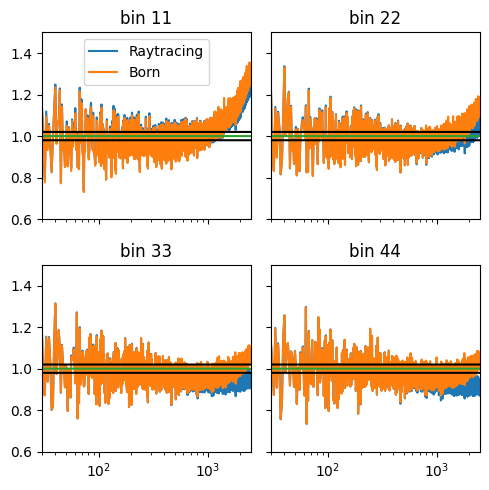

In [19]:
%matplotlib inline
output_predictions = '/global/cfs/cdirs/des/mgatti/Dirac/output_folder_cl_predictions_Dirac_sept23_2_noz25/'
f = glob.glob(output_predictions+'/*')

cl_pix = hp.sphtfunc.pixwin(config['nside_intermediate'])

output_measurements2= '/pscratch/sd/m/mgatti/pseudo_cl_test_Dirac_sept23/'
m = np.load(output_measurements2+'/k_{0}_{1}.npy'.format(folder,seed),allow_pickle=True).item()

    
max_l = 2500
for f_ in f:
    if ('runs{0}'.format(folder) in f_) and ('_run{0}'.format(mock_number) in f_):
       
        fig, ax = plt.subplots(2,2, figsize=(5,5.),sharex = True,sharey = True)
        
        tomo_bin = 1
        for i in range(2):
            for j in range(2):
                base = f_+'/shear_cl/bin_{0}_{0}.txt'.format(tomo_bin)
                base_l =  f_+'/shear_cl/ell.txt'
                cl = np.loadtxt(base)
                ell = np.loadtxt(base_l)
                mask = ell< 30000
                f = interp1d(ell[mask],(cl*ell)[mask])
                ll = np.arange(1,3000)
                theory = f(ll)[:max_l]*cl_pix[1:max_l+1]**2/ll[:max_l]


                
               
                #ax[i,j].plot(m['{0}_{0}'.format(tomo_bin)][:max_l]/theory) 
                ax[i,j].plot(cl_ray[tomo_bin][:max_l]/theory, label = 'Raytracing')
                ax[i,j].plot(cl_Born[tomo_bin][:max_l]/theory, label = 'Born')

                ax[i,j].plot(np.ones(len(ll)))
                ax[i,j].set_xscale('log')
                ax[i,j].set_xlim([30,max_l])      
                ax[i,j].set_ylim([0.6,1.5])
                ax[i,j].plot(0.98*np.ones(len(ll)),color='black')
                ax[i,j].plot(1.02*np.ones(len(ll)),color='black')
                ax[i,j].set_title('bin {0}{0}'.format(tomo_bin,tomo_bin))
                tomo_bin +=1
                
                
        ax[0,0].legend()
        plt.tight_layout()
        plt.show()

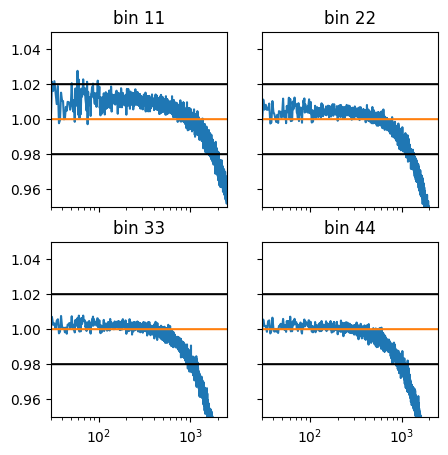

In [25]:
tomo_bin = 1
fig, ax = plt.subplots(2,2, figsize=(5,5.),sharex = True,sharey = True)
        
tomo_bin = 1
for i in range(2):
    for j in range(2):
        ax[i,j].plot(cl_ray[tomo_bin][:max_l]/cl_Born[tomo_bin][:max_l])
        
        
        
        ax[i,j].plot(np.ones(len(ll)))
        ax[i,j].set_xscale('log')
        ax[i,j].set_xlim([30,max_l])      
        ax[i,j].set_ylim([0.95,1.05])
        ax[i,j].plot(0.98*np.ones(len(ll)),color='black')
        ax[i,j].plot(1.02*np.ones(len(ll)),color='black')
        ax[i,j].set_title('bin {0}{0}'.format(tomo_bin,tomo_bin))
        tomo_bin +=1


# CLASS predictions

In [6]:
# this reads the cosmological parameter of the simulations
f = open(('/global/homes/m/mgatti/Mass_Mapping/peaks/params_run_1_Niall_{0}.txt'.format(folder)),'r')
om_ = []
ob_ = []
s8_ = []
h_ = []
w_ = []
ns_ = []
mv_ = []
for i,f_ in enumerate(f):
    if i>0:
        om_.append(float(f_.split(',')[0]))
        s8_.append(float(f_.split(',')[1]))
        w_.append(float(f_.split(',')[2]))
        ob_.append(float(f_.split(',')[3]))
        h_.append(float(f_.split(',')[4]))
        ns_.append(float(f_.split(',')[5]))
        try:
            mv_.append(float(f_.split(',')[6]))
        except:
            mv_.append(0.06)
    else:
        print (f_)

om_ = om_[seed-1]
ob_ = ob_[seed-1]
s8_ = s8_[seed-1]
h_  = h_ [seed-1]
w_  = w_ [seed-1]
ns_ = ns_[seed-1]
mv_ = mv_[seed-1]

# Omega_m, sigma_8, w, Omega_b, little_h, n_s



/tmp/ipykernel_6625/2622325578.py:53: RuntimeWarning: divide by zero encountered in divide
  plt.plot(cl_ray__[i-1][:2000]/((kappa1)[:2000]*cl_pix[:2000]**2),label = 'CLASS')


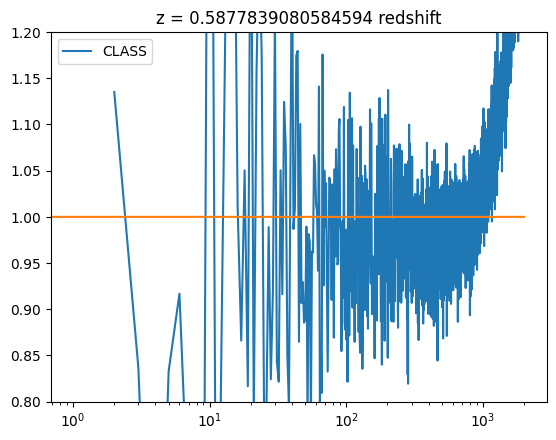

In [21]:
from classy import Class

i = 43
A0 = 2e-9
common_settings = {# LambdaCDM parameters
                    'h':h_,
                    'Omega_b':ob_,
                    'Omega_cdm':om_ - ob_,
                    'w0_fld': w_,  # Dark energy equation of state parameter w0 (you can adjust this value)
                    'wa_fld': 0.0,   # Dark energy equation of state parameter wa (if you want w to vary with time)
                    'Omega_fld': 1-om_,
                    'A_s': A0,
                    'n_s': ns_,
                    'format' :'CAMB',
                    'N_ur': 0.00641,  # This is often a small non-zero value for massless neutrinos
                    'N_ncdm': 3,  # Number of massive neutrino species
                    'm_ncdm': '{0}, {0}, {0}'.format(mv_/3),  # Example: Three neutrinos each with 0.1 eV mass
                   # output and precision parameters
                    'output':'sCl,tCl,pCl,lCl,mPk',    
                    'lensing': 'yes' ,
                    'selection':'dirac',
                    'selection_mean' : '{0:2.3f}'.format(raytrace_object.redshifts[i].value),
                    'l_max_lss':2048,
                    'non_linear':'halofit',
                    'z_max_pk':100.,
                    'l_switch_limber' : 40.,
                    'accurate_lensing':1,
                    'P_k_max_h/Mpc': 100}

M = Class()
M.set(common_settings)
M.compute()
r = s8_**2/M.sigma8()**2

# rescaling sigma8
M = Class()
common_settings['A_s'] *= r
M.set(common_settings)
M.compute()


ell = M.density_cl()['ell']
kappa1 = M.density_cl()['ll'][0] * (ell*(ell + 1)/2)**2
#
#lensing_cls = M.lensed_cl(2500) 

%matplotlib inline
cl_pix = hp.sphtfunc.pixwin(config['nside_intermediate'])



plt.title('z = {0}'.format(raytrace_object.redshifts[i]))
plt.plot(cl_ray__[i-1][:2000]/((kappa1)[:2000]*cl_pix[:2000]**2),label = 'CLASS')
plt.plot(np.ones((2000)))
plt.legend()
plt.xscale('log')
plt.ylim([0.8,1.2])
plt.show()

# Yuuki's implementation

In [16]:
# this reads the cosmological parameter of the simulations
f = open(('/global/homes/m/mgatti/Mass_Mapping/peaks/params_run_1_Niall_{0}.txt'.format(folder)),'r')
om_ = []
ob_ = []
s8_ = []
h_ = []
w_ = []
ns_ = []
mv_ = []
for i,f_ in enumerate(f):
    if i>0:
        om_.append(float(f_.split(',')[0]))
        s8_.append(float(f_.split(',')[1]))
        w_.append(float(f_.split(',')[2]))
        ob_.append(float(f_.split(',')[3]))
        h_.append(float(f_.split(',')[4]))
        ns_.append(float(f_.split(',')[5]))
        try:
            mv_.append(float(f_.split(',')[6]))
        except:
            mv_.append(0.06)
    else:
        print (f_)

om_ = om_[seed-1]
ob_ = ob_[seed-1]
s8_ = s8_[seed-1]
h_  = h_ [seed-1]
w_  = w_ [seed-1]
ns_ = ns_[seed-1]
mv_ = mv_[seed-1]

# Omega_m, sigma_8, w, Omega_b, little_h, n_s



In [21]:
# identify the redshift of the last slice
z_max = 3.4
try:
    imax = np.arange(len(raytrace_object.redshifts))[raytrace_object.redshifts>z_max][0]
except:
    imax = len(raytrace_object.redshifts)-1



Cosmo_ = cosmo(H0=h_*100., ombh2=ob_*h_**2, omch2=(om_-ob_)*h_**2,As = 2e-9,ns=ns_,mnu=mv_,num_massive_neutrinos=3 )
Theory = theory( cosmo= Cosmo_,halofit_version='takahashi', sigma_8 = s8_, chistar = raytrace_object.plane_distances[imax].value)
Theory.get_Wcmb()
Theory.get_Wcmblog()
Theory.limber(xtype = 'kklog',nonlinear=True) 
cl_z_max =  Theory.clkk[0][0]

Cosmo_ = cosmo(H0=h_*100., ombh2=ob_*h_**2, omch2=(om_-ob_)*h_**2,As = 2e-9,ns=ns_,mnu=mv_,num_massive_neutrinos=3 )
Theory = theory( cosmo= Cosmo_,halofit_version='takahashi', sigma_8 = s8_, chistar = None)
Theory.get_Wcmb()
Theory.get_Wcmblog()
Theory.limber(xtype = 'kklog',nonlinear=True) 
cl_CMB_lensing =  Theory.clkk[0][0]


DELTA_CL_CMB = cl_CMB_lensing-cl_z_max
DELTA_CL_CMB = np.hstack([0,DELTA_CL_CMB])
map_ = hp.sphtfunc.synfast(DELTA_CL_CMB,config['nside_intermediate'],pixwin=True)
cmb_lensing_map  = copy.deepcopy(raytrace_object.convergence_raytrace[imax-1]) + map_
cmb_lensing_map = hp.ud_grade(cmb_lensing_map, nside_out = config['nside'])

output = dict()
output['CMB_lensing_map'] = cmb_lensing_map
output['camb cl'] = cl_CMB_lensing

powers = Theory.results.get_cmb_power_spectra(Theory.pars, CMB_unit='muK')
output['camb_powers'] = powers


Om_b h^2             =  0.022315
Om_c h^2             =  0.151188
Om_nu h^2            =  0.000645
Om_darkenergy        =  0.639625
Om_K                 =  0.000000
Om_m (inc Om_u)      =  0.360324
100 theta (CosmoMC)  =  1.075763
N_eff (total)        =  3.044000
 3 nu, g= 3.0440 m_nu*c^2/k_B/T_nu0=    118.82 (m_nu=  0.020 eV)
Age of universe/GYr  =  12.870
zstar                =  1092.60
r_s(zstar)/Mpc       =  137.14
100*theta            =  1.075936
DA(zstar)/Gpc        =  12.74597
zdrag                =  1061.95
r_s(zdrag)/Mpc       =  139.65
k_D(zstar) Mpc       =  0.1490
100*theta_D          =  0.165451
z_EQ (if v_nu=1)     =  4147.21
k_EQ Mpc (if v_nu=1) =  0.012656
100*theta_EQ         =  0.726303
100*theta_rs_EQ      =  0.404368
tau_recomb/Mpc       =  266.11  tau_now/Mpc =  13011.8
Om_b h^2             =  0.022315
Om_c h^2             =  0.151188
Om_nu h^2            =  0.000645
Om_darkenergy        =  0.639625
Om_K                 =  0.000000
Om_m (inc Om_u)      =  0.360324


Om_b h^2             =  0.022315
Om_c h^2             =  0.151188
Om_nu h^2            =  0.000645
Om_darkenergy        =  0.639625
Om_K                 =  0.000000
Om_m (inc Om_u)      =  0.360324
100 theta (CosmoMC)  =  1.075763
N_eff (total)        =  3.044000
 3 nu, g= 3.0440 m_nu*c^2/k_B/T_nu0=    118.82 (m_nu=  0.020 eV)
Age of universe/GYr  =  12.870
zstar                =  1092.60
r_s(zstar)/Mpc       =  137.14
100*theta            =  1.075936
DA(zstar)/Gpc        =  12.74597
zdrag                =  1061.95
r_s(zdrag)/Mpc       =  139.65
k_D(zstar) Mpc       =  0.1490
100*theta_D          =  0.165451
z_EQ (if v_nu=1)     =  4147.21
k_EQ Mpc (if v_nu=1) =  0.012656
100*theta_EQ         =  0.726303
100*theta_rs_EQ      =  0.404368
tau_recomb/Mpc       =  266.11  tau_now/Mpc =  13011.8
Om_b h^2             =  0.022315
Om_c h^2             =  0.151188
Om_nu h^2            =  0.000645
Om_darkenergy        =  0.639625
Om_K                 =  0.000000
Om_m (inc Om_u)      =  0.360324


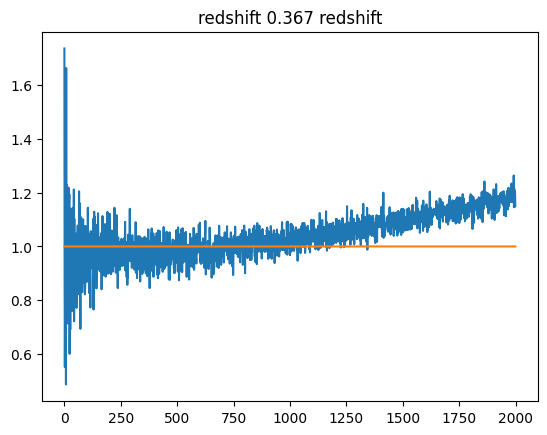

In [193]:
target_shell = 31
Cosmo_ = cosmo(H0=h_*100., ombh2=ob_*h_**2, omch2=(om_-ob_)*h_**2,As = 2e-9,ns=ns_,mnu=mv_,num_massive_neutrinos=3 )
Theory = theory( cosmo= Cosmo_,halofit_version='takahashi', sigma_8 = s8_, chistar = raytrace_object.plane_distances[target_shell].value)
Theory.get_Wcmb()
Theory.get_Wcmblog()
Theory.limber(xtype = 'kklog',nonlinear=True) 
cl_ Theory.clkk[0][0]

# how to make 

plt.plot(cl_born__2[target_shell-1][2:2002]/(Theory.clkk[0][0][1:2001]*cl_pix[1:2001]**2))#*(4*np.pi)/8)
plt.title('redshift {0:2.3f}'.format(raytrace_object.redshifts[target_shell]))
plt.plot(np.ones(2000))
         